In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Activation, dot, concatenate
from keras.models import Model

import encoding

In [ ]:
LEARNING_RATE = 0.5
BATCH_SIZE = 64
HIDDEN_NODES = 256
NUMBER_OF_LAYERS = 2
EMB_SIZE=70
EPOCHS=13

In [ ]:
data = pd.concat([pd.read_csv('poetry.csv'), \
                  pd.read_csv('news.csv'), \
                  pd.read_csv('dictionary.csv')],
                 ignore_index=True)

In [ ]:
import string

to_replace = str.maketrans('', '', string.punctuation)
to_replace.update({ord('-'):ord('-'), ord('«'):'', ord('»'):'', ord('،'):'', ord('؟'):'', \
                   ord('\xad'):'', ord('…'):'', ord('’'):'', ord('—'):ord('—'), ord('ـ'):32, ord('\xa0'):32, \
                   ord('−'):ord('—'), ord('–'):ord('—'), ord('؛'):'', ord('”'):'', ord('“'):''})

def no_punct(df, col):
    data = '\n'.join(df[col].tolist()).split('\n')
    return [str(s).strip().lower().translate(to_replace) for s in data]

In [ ]:
def train_test_val(data_input, data_output, tr_size=0.8, te_size=0.05, r_state=13):

    training_input, validation_input, training_output, validation_output  = \
    train_test_split(data_input, data_output, train_size=tr_size, random_state=r_state)
    validation_input, testing_input, validation_output, testing_output = \
    train_test_split(validation_input, validation_output, test_size=te_size, random_state=r_state)

    return {'train_in':training_input, 'train_out':training_output, \
            'val_in':validation_input, 'val_out':validation_output, \
            'test_in':testing_input, 'test_out':testing_output}


In [ ]:
data_input, data_output = no_punct(data, 'tj'), no_punct(data, 'pers')

data_split = train_test_val(data_input, data_output)

training_input, training_output = data_split['train_in'], data_split['train_out']
validation_input, validation_output = data_split['val_in'], data_split['val_out']
testing_input, testing_output = data_split['test_in'], data_split['test_out']

In [ ]:
print(data_input[0], data_output[0])

сипос аз худо — эзиди раҳнамой سپاس از خدا ایزد رهنمای


In [ ]:
print('data size', len(data_input))

print(training_input[0], training_output[0])
print(testing_input[-1], testing_output[-1])

print('training size', len(training_input))
print('validation size', len(validation_input))
print('test size', len(testing_input))

data size 113105
лалмикорӣ للمیکاری
ситора даҳ аз дебаи ранг-ранг ستاره ده از دیبهٔ رنگ رنگ
training size 90484
validation size 21489
test size 1132


In [ ]:
INPUT_LENGTH = len(max(data_input, key=len))
OUTPUT_LENGTH = len(max(data_output, key=len))
print("max input len =", INPUT_LENGTH,"\nmax output len =",OUTPUT_LENGTH)

max input len = 69 
max output len = 67


## Transform data into Numpy arrays
We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in encoding module.

First, encoding.build_characters_encoding will build encoding/decoding dictionary from the data.
Then, encoding.transform will transform the data into numpy array.

In [ ]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('Tajik character dict size:', input_dict_size)
print('Persian character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

Tajik character dict size: 42
Persian character dict size: 42
encoded_training_input (90484, 69)
encoded_training_output (90484, 67)
encoded_validation_input (21489, 69)
encoded_validation_output (21489, 67)


In [ ]:
# The order of the dictionary characters have to be saved separately

import pickle

vars = [input_decoding, input_encoding, output_decoding, output_encoding, \
        INPUT_LENGTH,OUTPUT_LENGTH, input_dict_size, output_dict_size]
with open('variables_12.txt', 'wb') as f:
  pickle.dump(vars, f)

# Sequence-to-Sequence in Keras

In [ ]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder


In [ ]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, EMB_SIZE, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(HIDDEN_NODES, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, EMB_SIZE, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(HIDDEN_NODES, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder KerasTensor(type_spec=TensorSpec(shape=(None, 69, 256), dtype=tf.float32, name=None), name='lstm/transpose_2:0', description="created by layer 'lstm'")
encoder_last KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
decoder KerasTensor(type_spec=TensorSpec(shape=(None, 67, 256), dtype=tf.float32, name=None), name='lstm_1/transpose_2:0', description="created by layer 'lstm_1'")


### Attention Mechanism
Reference: <a href="https://arxiv.org/pdf/1508.04025.pdf">Effective Approaches to Attention-based Neural Machine Translation</a>'s Global Attention with Dot-based scoring function (Section 3, 3.1)

In [ ]:
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

output = TimeDistributed(Dense(HIDDEN_NODES, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)

attention KerasTensor(type_spec=TensorSpec(shape=(None, 67, 69), dtype=tf.float32, name=None), name='attention/Softmax:0', description="created by layer 'attention'")
context KerasTensor(type_spec=TensorSpec(shape=(None, 67, 256), dtype=tf.float32, name=None), name='dot_1/MatMul:0', description="created by layer 'dot_1'")
decoder_combined_context KerasTensor(type_spec=TensorSpec(shape=(None, 67, 512), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
output KerasTensor(type_spec=TensorSpec(shape=(None, 67, 42), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [ ]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(top_k=2), 'categorical_accuracy'])

### Training the model

In [ ]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [ ]:
history = None
history = model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=BATCH_SIZE, epochs=EPOCHS)
model.save('model_12-7.h5')

1414/1414 - 1406s - loss: 0.0214 - precision: 0.9794 - recall: 0.9964 - categorical_accuracy: 0.9779 - val_loss: 0.0429 - val_precision: 0.9639 - val_recall: 0.9907 - val_categorical_accuracy: 0.9619 - 1406s/epoch - 994ms/step


In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn

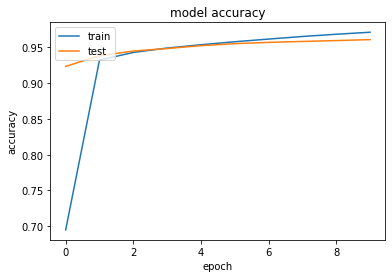

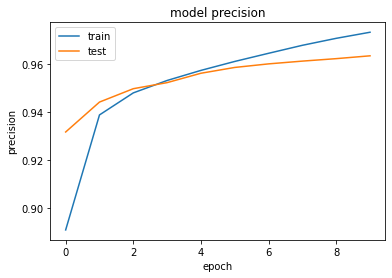

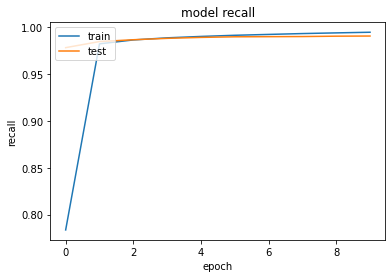

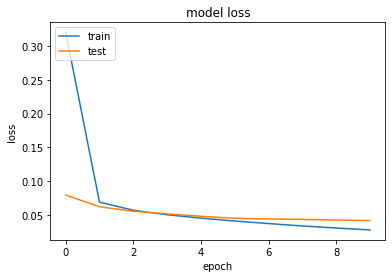

In [ ]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing the model


In [ ]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], INPUT_LENGTH)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input [:,1:]

def decode(sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_persian(text):
    decoder_output = generate(text)
    return decode(decoder_output[0])

# check strings of different length

test_words = ['эй дӯст биё то ғами фардо нахӯрем', 'нахӯрем', 'фардо нахӯрем', 'ғами фардо нахӯрем', 'то ғами фардо нахӯрем', 'биё то ғами фардо нахӯрем', 'эй дӯст биё то', 'эй дӯст биё', 'эй дӯст']
test_result = []
for name in test_words:
    test_result.append(to_persian(name))
print(*test_result, sep='\n')
print('ای دوست بیا تا غمِ فردا نخوریم')

1/1 [==============================] - 0s 39ms/step
‌ای دوست بیا تا غم فردا نخوریم
نخوریم
فردا نخوریم
غم فردا نخوریم
تا غم فردا نخوریم
بیا تا غم فردا نخوریم
ای دوست بیا تا
ای دوست بیا
ای دوست
ای دوست بیا تا غمِ فردا نخوریم


## Test Data

In [ ]:
test_input = testing_input[:500]
test_output = testing_output[:500]
print('testing size', len(test_output))

testing size 500


In [ ]:
test_input[-1]

'коса бар косасту нон бар нон мудом'

In [ ]:
refer = [t for t in test_output]
predict = [to_persian(s) for s in test_input]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 56ms/step


In [ ]:
def accuracy(refs, preds):
    accuracy_score = []
    for ref, pred in zip(refs, preds):
        right_words = 0
        for word in ref:
            if word in pred: right_words +=1
        accuracy_score.append(right_words / max(len(pred), len(ref)))
    return sum(accuracy_score) / len(accuracy_score)

refs = [r.strip().split() for r in refer]
preds = [p.strip().split() for p in predict]

print('Accuracy rate =', accuracy(refs, preds))

Accuracy rate = 0.7221569985569988


In [ ]:
with open("ref_12-6.txt", "w") as ref:
    ref.write('\n'.join(refer))
with open("pred_12-6.txt", "w") as pred:
    pred.write('\n'.join(predict))